In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import json

In [3]:
path_results = "test_results/19A_19B/"

In [17]:
def read_json(file_path):
    with open(file_path) as file:
        return file.read()

In [14]:
f_dict = read_files(path_results + "f_word_dictionaries.json")

In [15]:
r_dict = read_files(path_results + "r_word_dictionaries.json")

In [32]:
def read_txt(file_path):
    data = None
    with open(file_path) as file:
        data = file.read()
    data = data.split("\n")
    data = data[:len(data) - 1]
    data = [float(i) for i in data]
    return data

In [43]:
pretr_gen_loss = read_txt(path_results + "pretr_gen_loss.txt")
tr_gen_true_loss = read_txt(path_results + "tr_gen_true_loss.txt")
tr_gen_loss = read_txt(path_results + "tr_gen_loss.txt")
tr_disc_loss = read_txt(path_results + "tr_disc_loss.txt")

epochs = np.arange(0, 5)
epochs

array([0, 1, 2, 3, 4])

[0.0065572867169976234,
 0.006072596181184053,
 0.005972938612103462,
 0.005715757608413696,
 0.005718160420656204]

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

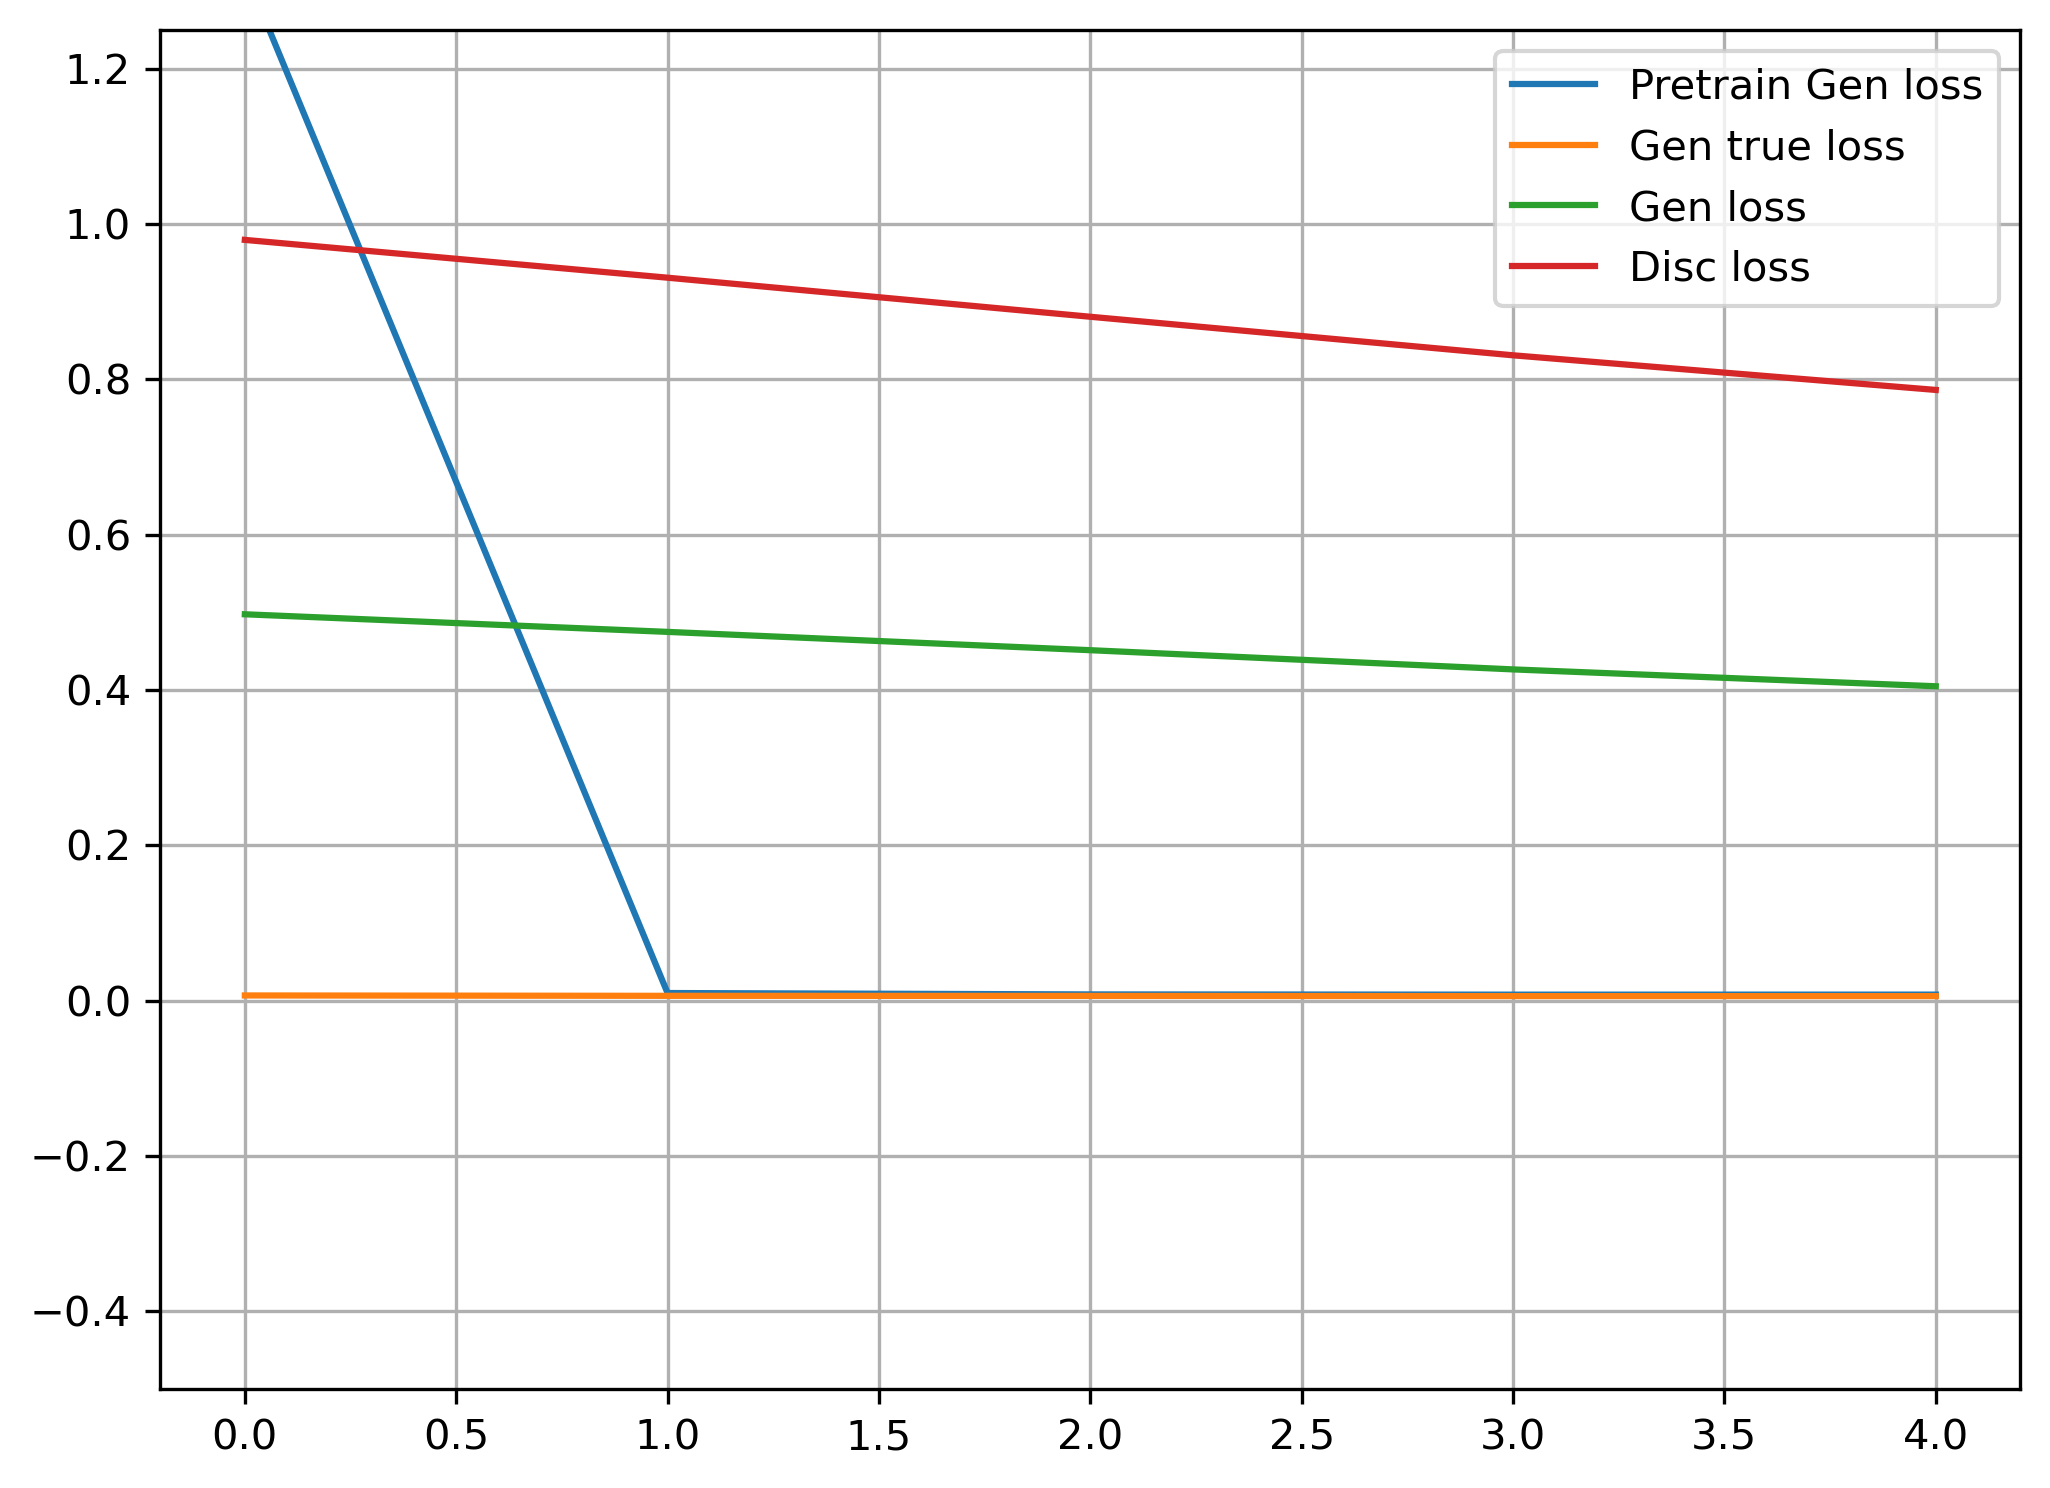

In [77]:
#dataframe = pd.DataFrame(list(zip(epochs, pretr_gen_loss, tr_gen_true_loss, tr_gen_loss, tr_disc_loss)), columns=["Epochs", "Pretrain gen loss","Tr gen true loss", "Tr gen loss", "Tr disc loss"])
plt.figure(figsize=(8, 6), dpi=300)

plt.plot(epochs, pretr_gen_loss)
plt.plot(epochs, tr_gen_true_loss)
plt.plot(epochs, tr_gen_loss)
plt.plot(epochs, tr_disc_loss)
plt.ylim(-0.5, 1.25)
plt.legend(["Pretrain Gen loss", "Gen true loss", "Gen loss", "Disc loss"])
plt.grid(True)
plt.show()

In [79]:
df_true_pred = pd.read_csv(path_results + "true_predicted_df.csv")
df_true_pred

,True_X,True_Y,Predicted_Y
0,"13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,..."
1,"13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,..."
2,"13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,..."
3,"13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,..."
4,"13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,..."
...,...,...,...
77,"13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,..."
78,"13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,..."
79,"13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,..."
80,"13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,..."


In [145]:
cols = list(df_true_pred.columns)

for index, row in df_true_pred.iterrows():
    true_x = row[cols[0]].split(",")
    true_y = row[cols[1]].split(",")
    pred_y = row[cols[2]].split(",")
    space = 1
    for i in range(len(true_x)):
        first = true_x[i:i+space]
        sec = pred_y[i:i+space]

        first = [f_dict[j] for j in first]
        sec = [f_dict[j] for j in sec]

        intersection = set(first).difference(set(sec))

        if len(intersection) > 0:
            #print()
            print(index, i+1, intersection)
            #print()
            print(first)
            #print()
            print(sec)
            print("-------------")  
    

0 653 {'V'}
['V']
['A']
-------------
1 255 {'X'}
['X']
['S']
-------------
1 256 {'X'}
['X']
['S']
-------------
1 257 {'X'}
['X']
['G']
-------------
1 258 {'X'}
['X']
['W']
-------------
1 259 {'X'}
['X']
['T']
-------------
1 260 {'X'}
['X']
['A']
-------------
1 261 {'X'}
['X']
['G']
-------------
1 262 {'X'}
['X']
['A']
-------------
1 263 {'X'}
['X']
['A']
-------------
1 264 {'X'}
['X']
['A']
-------------
1 265 {'X'}
['X']
['Y']
-------------
1 266 {'X'}
['X']
['Y']
-------------
1 267 {'X'}
['X']
['V']
-------------
1 268 {'X'}
['X']
['G']
-------------
1 269 {'X'}
['X']
['Y']
-------------
1 270 {'X'}
['X']
['L']
-------------
1 271 {'X'}
['X']
['Q']
-------------
1 272 {'X'}
['X']
['P']
-------------
1 273 {'X'}
['X']
['R']
-------------
1 274 {'X'}
['X']
['T']
-------------
1 275 {'X'}
['X']
['F']
-------------
1 276 {'X'}
['X']
['L']
-------------
1 277 {'X'}
['X']
['L']
-------------
1 278 {'X'}
['X']
['K']
-------------
1 279 {'X'}
['X']
['Y']
-------------
1 280 {'X'}


41 231 {'X'}
['X']
['I']
-------------
41 232 {'X'}
['X']
['G']
-------------
41 233 {'X'}
['X']
['I']
-------------
41 234 {'X'}
['X']
['N']
-------------
41 235 {'X'}
['X']
['I']
-------------
41 236 {'X'}
['X']
['T']
-------------
41 237 {'X'}
['X']
['R']
-------------
41 238 {'X'}
['X']
['F']
-------------
41 239 {'X'}
['X']
['Q']
-------------
41 240 {'X'}
['X']
['T']
-------------
41 241 {'X'}
['X']
['L']
-------------
41 242 {'X'}
['X']
['L']
-------------
41 243 {'X'}
['X']
['A']
-------------
41 496 {'X'}
['X']
['G']
-------------
41 497 {'X'}
['X']
['F']
-------------
41 498 {'X'}
['X']
['Q']
-------------
41 499 {'X'}
['X']
['P']
-------------
41 500 {'X'}
['X']
['T']
-------------
41 501 {'X'}
['X']
['N']
-------------
41 502 {'X'}
['X']
['G']
-------------
41 503 {'X'}
['X']
['V']
-------------
41 504 {'X'}
['X']
['G']
-------------
41 505 {'X'}
['X']
['Y']
-------------
41 506 {'X'}
['X']
['Q']
-------------
41 507 {'X'}
['X']
['P']
-------------
41 508 {'X'}
['X']
['Y']


74 260 {'X'}
['X']
['A']
-------------
74 261 {'X'}
['X']
['G']
-------------
74 262 {'X'}
['X']
['A']
-------------
74 263 {'X'}
['X']
['A']
-------------
74 264 {'X'}
['X']
['A']
-------------
74 265 {'X'}
['X']
['Y']
-------------
74 266 {'X'}
['X']
['Y']
-------------
74 267 {'X'}
['X']
['V']
-------------
74 268 {'X'}
['X']
['G']
-------------
74 269 {'X'}
['X']
['Y']
-------------
74 270 {'X'}
['X']
['L']
-------------
74 271 {'X'}
['X']
['Q']
-------------
74 272 {'X'}
['X']
['P']
-------------
74 273 {'X'}
['X']
['R']
-------------
74 274 {'X'}
['X']
['T']
-------------
74 275 {'X'}
['X']
['F']
-------------
74 276 {'X'}
['X']
['L']
-------------
74 277 {'X'}
['X']
['L']
-------------
74 278 {'X'}
['X']
['K']
-------------
74 279 {'X'}
['X']
['Y']
-------------
74 280 {'X'}
['X']
['N']
-------------
74 281 {'X'}
['X']
['E']
-------------
74 282 {'X'}
['X']
['N']
-------------
74 283 {'X'}
['X']
['G']
-------------
74 284 {'X'}
['X']
['T']
-------------
74 285 {'X'}
['X']
['I']
